### Imports and Loading Data:

In [3]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from pyvis.network import Network
from cdlib import algorithms

df = pd.read_csv("country_relationships_20th_century.csv")
source_col = "source"
target_col = "target"
weight_col = "weight"

### Create the NetworkX graph:

In [5]:
# Create weighted graph from dataframe
weight_col = "weight"
G = nx.from_pandas_edgelist(
    df,
    source=source_col,
    target=target_col,
    edge_attr=weight_col,
    create_using=nx.Graph()
)
# For convenience, set a standard 'weight' attribute name
for u, v, data in G.edges(data=True):
    data["weight"] = data.get(weight_col, 1)

### Graph 1 – Static NetworkX graph:

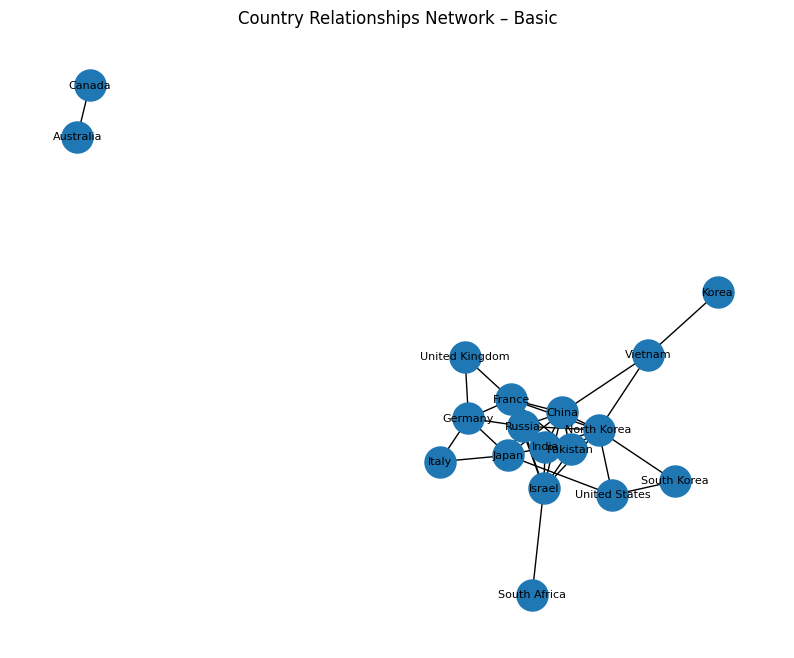

In [6]:
plt.figure(figsize=(10, 8))

pos = nx.spring_layout(G, seed=42) 

nx.draw_networkx_nodes(G, pos, node_size=500)
nx.draw_networkx_edges(G, pos)  # simple edges
nx.draw_networkx_labels(G, pos, font_size=8)

plt.title("Country Relationships Network – Basic")
plt.axis("off")
plt.show()

### Graph 2 – Pyvis interactive graph (edge width proportional to relationship):

In [7]:
# Create PyVis network
net = Network(height="750px", width="100%", notebook=True)
net.barnes_hut()

# Add nodes
for node in G.nodes():
    net.add_node(str(node), label=str(node))

# Add edges with proportional width
for u, v, data in G.edges(data=True):
    w = data.get("weight", 1)
    net.add_edge(str(u), str(v), value=w)  

# Save and show
net.show("network_graph_2_relationship_width.html")

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


### Apply Leiden algorithm (community detection):

In [8]:
# Run Leiden community detection
# weights="weight" uses the weighted relationships
communities = algorithms.leiden(G, weights="weight")

# communities.communities is a list of lists of nodes
# Assign a community id to each node as a node attribute
node_to_comm = {}
for i, comm in enumerate(communities.communities):
    for node in comm:
        node_to_comm[node] = i

nx.set_node_attributes(G, node_to_comm, "community")

### Graph 3 – Pyvis interactive graph with Leiden communities:

In [9]:
net_comm = Network(height="750px", width="100%", notebook=True)
net_comm.barnes_hut()

# Assign distinct groups based on community id
for node, data in G.nodes(data=True):
    comm_id = data.get("community", 0)
    net_comm.add_node(
        str(node),
        label=str(node),
        group=comm_id  
    )

for u, v, data in G.edges(data=True):
    w = data.get("weight", 1)
    net_comm.add_edge(str(u), str(v), value=w)

net_comm.show("network_graph_3_leiden_communities.html")

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


#### Observations:
Which countries cluster together?

Do the communities correspond to historical alliances/blocs? (e.g., Allied vs Axis, Cold War blocs, regional alliances)

Are there “bridge” countries connecting communities?

### Centrality measures + bar charts:

#### 1:Calculate centralities

In [11]:
# Degree centrality
deg_centrality = nx.degree_centrality(G)

# Closeness centrality
closeness_centrality = nx.closeness_centrality(G, distance=None)

# Betweenness centrality (weighted)
betweenness_centrality = nx.betweenness_centrality(
    G,
    weight="weight",
    normalized=True
)

#### 2:Plot degree centrality (bar chart)

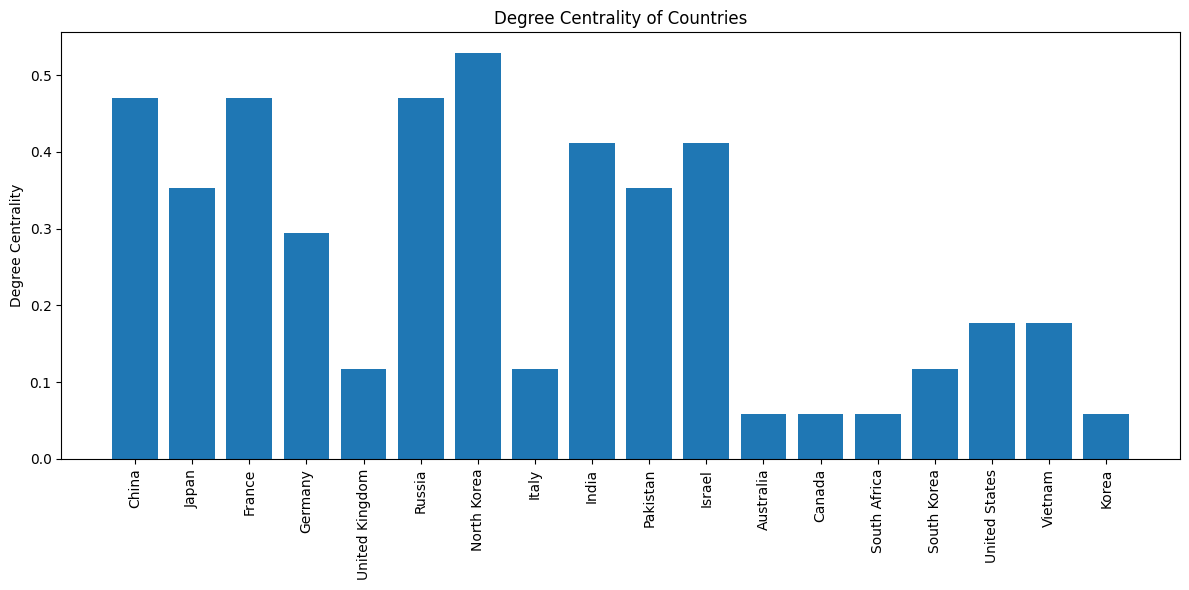

In [12]:
plt.figure(figsize=(12, 6))

countries = list(deg_centrality.keys())
values = [deg_centrality[c] for c in countries]

plt.bar(countries, values)
plt.xticks(rotation=90)
plt.ylabel("Degree Centrality")
plt.title("Degree Centrality of Countries")
plt.tight_layout()
plt.show()

#### Observations:
Which countries have the highest degree centrality?

These are the most directly connected countries in the network.

Do they correspond to historically central powers (e.g., major allies, colonial empires, superpowers)?

#### 3:Plot closeness centrality (bar chart)

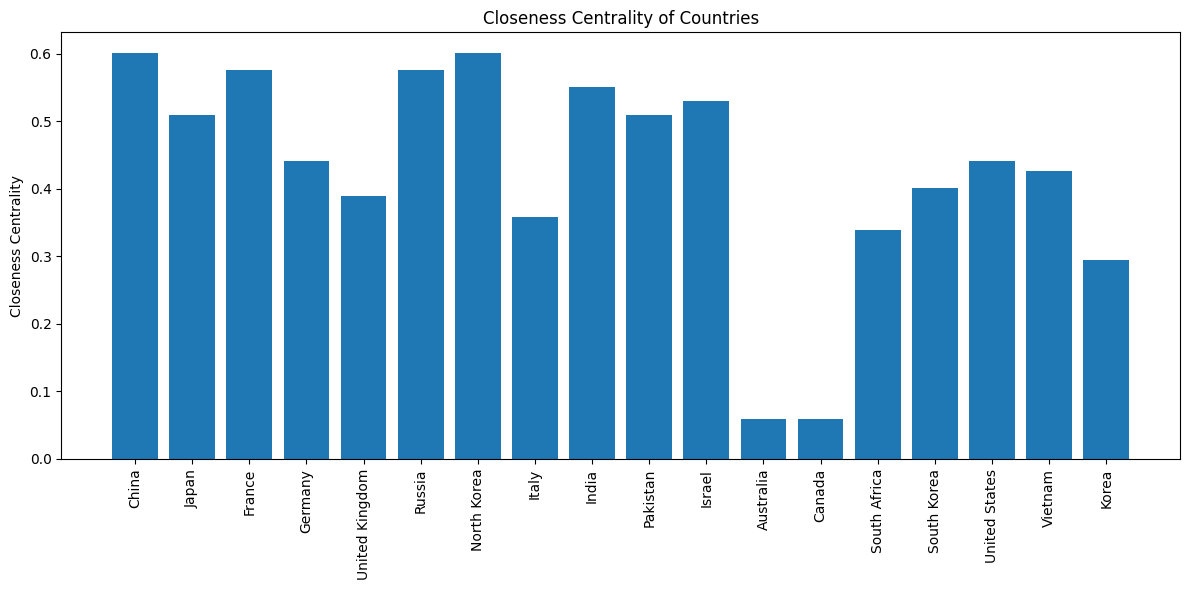

In [13]:
plt.figure(figsize=(12, 6))

countries = list(closeness_centrality.keys())
values = [closeness_centrality[c] for c in countries]

plt.bar(countries, values)
plt.xticks(rotation=90)
plt.ylabel("Closeness Centrality")
plt.title("Closeness Centrality of Countries")
plt.tight_layout()
plt.show()

Higher closeness means a country is, on average, “closer” to all others.

These countries can quickly reach others through short paths → historically, perhaps diplomatic hubs, major powers, etc.

#### 4:Plot betweenness centrality (bar chart)

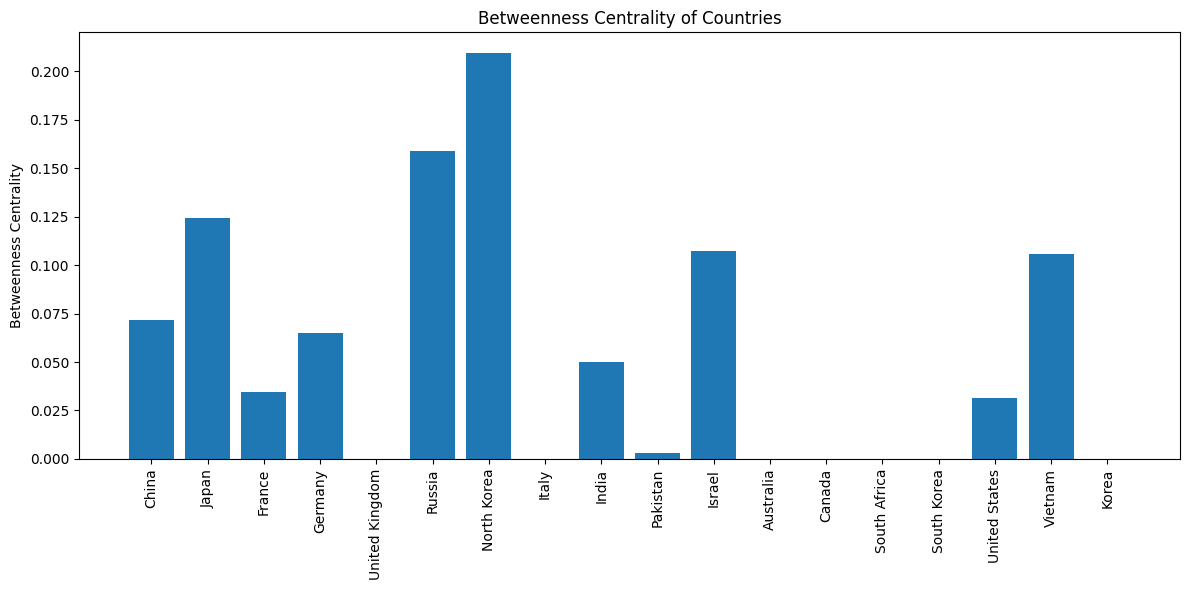

In [14]:
plt.figure(figsize=(12, 6))

countries = list(betweenness_centrality.keys())
values = [betweenness_centrality[c] for c in countries]

plt.bar(countries, values)
plt.xticks(rotation=90)
plt.ylabel("Betweenness Centrality")
plt.title("Betweenness Centrality of Countries")
plt.tight_layout()
plt.show()

High betweenness → countries that act as “bridges” between different groups.

Historically, these may be nations that mediated between blocs, or geographically/strategically positioned in between alliances.